<a href="https://colab.research.google.com/github/carsonyan/interpretation/blob/master/NLP_Week4_Exercise_Shakespeare_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras.regularizers import L1, L2
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [ ]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-01-03 15:24:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.164.176, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-03 15:24:35 (117 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [ ]:
predictors[78]

array([  0,   0,   0,   0,   0,   0,   0, 257,   2,  94], dtype=int32)

In [ ]:
total_words

3211

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150,return_sequences = True)))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=L2(0.01))) #L1 leads to a bad result
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 128)           411008    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 300)           334800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_7 (Dense)              (None, 3211)              5156866   
Total params: 6,225,179
Trainable params: 6,225,179
Non-trainable params: 0
____________________________________________

In [ ]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 10s 14ms/step - loss: 7.3521 - accuracy: 0.0206
Epoch 2/100
484/484 [==============================] - 7s 14ms/step - loss: 6.4601 - accuracy: 0.0207
Epoch 3/100
484/484 [==============================] - 7s 13ms/step - loss: 6.4259 - accuracy: 0.0239
Epoch 4/100
484/484 [==============================] - 7s 13ms/step - loss: 6.2773 - accuracy: 0.0288
Epoch 5/100
484/484 [==============================] - 7s 14ms/step - loss: 6.1774 - accuracy: 0.0369
Epoch 6/100
484/484 [==============================] - 6s 13ms/step - loss: 6.0618 - accuracy: 0.0401
Epoch 7/100
484/484 [==============================] - 6s 13ms/step - loss: 5.9873 - accuracy: 0.0429
Epoch 8/100
484/484 [==============================] - 6s 13ms/step - loss: 5.8927 - accuracy: 0.0451
Epoch 9/100
484/484 [==============================] - 6s 13ms/step - loss: 5.8072 - accuracy: 0.0529
Epoch 10/100
484/484 [==============================] - 6s 13ms/step - loss: 5.70

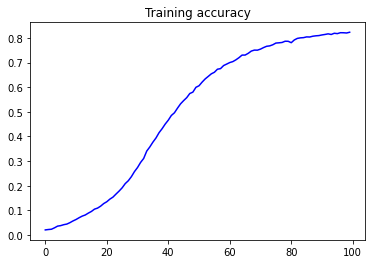

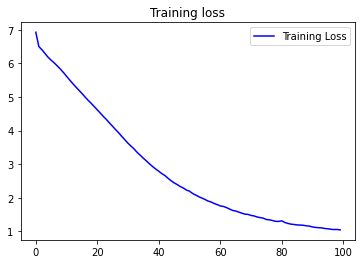

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)